# Time Series Analysis

Sources:
- https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
- https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
- https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
import matplotlib.dates as mdates
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf
from darts import TimeSeries
from darts.backtesting import backtest_forecasting
from darts.metrics import mape
from darts.preprocessing import ScalerWrapper
from darts.models import RNNModel, ExponentialSmoothing, AutoARIMA, Prophet
from darts.models.tcn_model import TCNModel

In [4]:
def summary_view(data_list):
    fig = make_subplots(rows=1, cols=3,
                        specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]])

    fig.add_trace(
        go.Indicator(
            mode="number",
            value=sum(data_list[0].iloc[:, -2]),
            title="Cases",
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Indicator(
            mode="number",
            value=sum(data_list[1].iloc[:, -2]),
            title="Recovered",
        ),
        row=1, col=2
    )

    fig.add_trace(
        go.Indicator(
            mode="number",
            value=sum(data_list[2].iloc[:, -2]),
            title="Deaths",
        ),
        row=1, col=3
    )

    fig.update_layout(height=200, width=600, title_text="Today Summary")
    # st.plotly_chart(fig)
    return fig

In [5]:
def header_view(data_list):
    message = data_list[0]["Country/Region"] + "<br>"
    message += "Confirmed: " + data_list[0].iloc[:, -2].astype(str)

    fig2 = go.Figure(data=go.Scattergeo(
        locationmode="country names",
        lon=data_list[0]["Long"],
        lat=data_list[0]["Lat"],
        hovertext=message,
        showlegend=False,
        marker=dict(
            size=7,
            opacity=0.9,
            reversescale=True,
            autocolorscale=True,
            line=dict(
                width=1,
            ),
            cmin=0,
            color=data_list[0].iloc[:, -3],
            cmax=max(data_list[0].iloc[:, -3]),
            colorbar_title="Live Confirmed Cases",
        )),
    )

    fig2.update_layout(
        title="COVID-19 Worldwide Cases",
        showlegend=True,
        legend=dict(x=0.65, y=0.8),
        geo=dict(
            projection_type="orthographic",
            showcoastlines=True,
            showland=True,
            showocean=True,
            lakecolor="LightBlue"
        ),
    )

    # st.plotly_chart(fig)
    return fig2

In [6]:
def world_map(resources, df2):
    datasets = []
    for link in resources:
        df = pd.read_csv(link)
        df = df[df['Country/Region'] != 'Diamond Princess']
        df = df[df['Country/Region'] != 'MS Zaandam']
        if len(datasets) == 0:
            fig2 = header_view([df])
        df = df.drop(['Province/State'], axis=1)
        df = df.reset_index(drop=True)
        df = df.groupby('Country/Region').sum()
        df = df.reset_index()
        df.loc[df.loc[df['Country/Region'] == 'US'].index,
               'Country/Region'] = 'United States of America'
        df.loc[df.loc[df['Country/Region'] == 'United Kingdom'].index,
               'Country/Region'] = 'United Kingdom of Great Britain and Northern Ireland'
        df.loc[df.loc[df['Country/Region'] == 'Russia'].index,
               'Country/Region'] = 'Russian Federation'
        df.loc[df.loc[df['Country/Region'] == 'Venezuela'].index,
               'Country/Region'] = 'Venezuela (Bolivarian Republic of)'
        df.loc[df.loc[df['Country/Region'] == 'Bolivia'].index,
               'Country/Region'] = 'Bolivia (Plurinational State of)'
        df.loc[df.loc[df['Country/Region'] == 'Taiwan*'].index,
               'Country/Region'] = 'Taiwan, Province of China'
        df.loc[df.loc[df['Country/Region'] == 'Syria'].index,
               'Country/Region'] = 'Syrian Arab Republic'
        df.loc[df.loc[df['Country/Region'] == 'Korea, South'].index,
               'Country/Region'] = 'Korea, Republic of'
        df.loc[df.loc[df['Country/Region'] == 'Iran'].index,
               'Country/Region'] = 'Iran (Islamic Republic of)'
        df.loc[df.loc[df['Country/Region'] == 'Cote d\'Ivoire'].index,
               'Country/Region'] = 'Côte d\'Ivoire'
        df.loc[df.loc[df['Country/Region'] ==
                      'Congo (Kinshasa)'].index, 'Country/Region'] = 'Congo, Democratic Republic of the'
        df.loc[df.loc[df['Country/Region'] ==
                      'Congo (Brazzaville)'].index, 'Country/Region'] = 'Congo'
        df.loc[df.loc[df['Country/Region'] == 'Moldova'].index,
               'Country/Region'] = 'Moldova, Republic of'
        df.loc[df.loc[df['Country/Region'] == 'Tanzania'].index,
               'Country/Region'] = 'Tanzania, United Republic of'
        df.loc[df.loc[df['Country/Region'] == 'Brunei'].index,
               'Country/Region'] = 'Brunei Darussalam'
        code2 = []
        for i in df['Country/Region']:
            try:
                code2.append(df2[df2['name'] == i]['alpha-3'].values[0])
            except:
                code2.append('NA')

        df['code'] = code2
        df.loc[df.loc[df['Country/Region'] == 'United Kingdom of Great Britain and Northern Ireland'].index,
               'Country/Region'] = 'United Kingdom'
        datasets.append(df)

    fig = summary_view(datasets)

    for i in range(len(datasets)):
        datasets[i] = datasets[i].drop(
            ['Lat', 'Long'], axis=1)
        datasets[i] = datasets[i].melt(
            id_vars=["Country/Region", "code"],
            var_name="Dates",
            value_name="Cases")

    return datasets, fig, fig2

In [7]:
df2 = pd.read_csv('../data/all.csv')
resources = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
             'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv',
             'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
             ]

data_list, fig, fig2 = world_map(resources, df2)

In [8]:
data_list[0].set_index('Dates', inplace=True)
data_list[1].set_index('Dates', inplace=True)
data_list[2].set_index('Dates', inplace=True)
#data_list[0].index = data_list[0].index.map(str)
data_list[0]

,Country/Region,code,Cases
Dates,,,
1/22/20,Afghanistan,AFG,0
1/22/20,Albania,ALB,0
1/22/20,Algeria,DZA,0
1/22/20,Andorra,AND,0
1/22/20,Angola,AGO,0
...,...,...,...
7/8/20,West Bank and Gaza,NA,5029
7/8/20,Western Sahara,ESH,10
7/8/20,Yemen,YEM,1318


In [10]:
place= 'Italy'
data_list[0][data_list[0]['Country/Region']==place]['Cases']

Dates
1/22/20         0
1/23/20         0
1/24/20         0
1/25/20         0
1/26/20         0
            ...  
7/4/20     241419
7/5/20     241611
7/6/20     241819
7/7/20     241956
7/8/20     242149
Name: Cases, Length: 169, dtype: int64

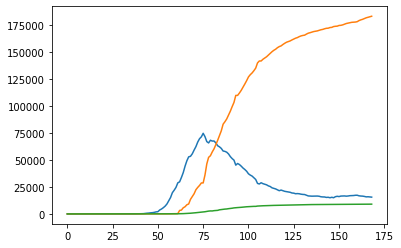

In [164]:
place = 'Germany'
plt.plot(data_list[0][data_list[0]['Country/Region']==place]['Cases'].values - data_list[1][data_list[1]['Country/Region']==place]['Cases'].values)
plt.plot(data_list[1][data_list[0]['Country/Region']==place]['Cases'].values)
plt.plot(data_list[2][data_list[0]['Country/Region']==place]['Cases'].values)

# SIR Time Series Prediction

In [306]:
def SIR(t, y, beta, gamma):
    S, I, R = y
    dsdt = -beta * I * S
    didt = beta * I * S - gamma * I
    drdt = gamma * I
    return dsdt, didt, drdt

def time_extend_index(index, new_size):
    values = index.values
    current = datetime.strptime(index[-1], '%m/%d/%y')
    while len(values) < new_size:
        current = current + timedelta(days=1)
        values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
    return values

def predict(beta, gamma, cases, recovered, place, days, s0, i0, r0):
    new_index = time_extend_index(cases.index, days)
    extended = []
    for i in [cases, recovered]:
        extended.append(np.concatenate((i.values, [None] * (len(new_index) - len(i.values)))))
    step = solve_ivp(SIR, [0, len(new_index)], [s0,i0,r0], args=(beta, gamma), t_eval=np.arange(0, len(new_index), 1))
    return new_index, extended, step

def loss(point, cases, recovered, s0, i0, r0):
    beta, gamma = point
    alpha = 0.1
    solution = solve_ivp(SIR, [0, len(cases)], [s0,i0,r0], args=(beta, gamma), t_eval=np.arange(0, len(cases), 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - cases)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    return alpha * l1 + (1 - alpha) * l2

def SIR_series(data_list, place, days, s0, i0, r0):
    cases = data_list[0][data_list[0]['Country/Region']==place]['Cases'] - data_list[1][data_list[1]['Country/Region']==place]['Cases']
    recovered = data_list[1][data_list[1]['Country/Region']==place]['Cases']
    days = len(cases.index) + days
    optimal = minimize(loss, [0.001, 0.001], args=(cases, recovered, s0, i0, r0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    print(f"country={place}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    new_index, extended, prediction = predict(beta, gamma, cases, recovered, place, days, s0, i0, r0)
    df = pd.DataFrame({'Infected': prediction.y[1], 'Infected (Data)': extended[0],
                        'Recovered': prediction.y[2], 'Recovered (Data)': extended[1]},  
                      index=new_index)
    return df

def sir_pred_plot(df, place):
    plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    new_x = mdates.datestr2num(df.index)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
    plt.plot(new_x, df['Infected'].values, label='Infected')
    plt.plot(new_x, df['Infected (Data)'].values, label='Infected (Data)')
    plt.plot(new_x, df['Recovered'].values, label='Recovered')
    plt.plot(new_x, df['Recovered (Data)'].values, label='Recovered (Data)')
    plt.gcf().autofmt_xdate()
    plt.legend(fontsize=14)
    plt.title("SIR " + str(place) + " Forecasting", fontsize=20)
    plt.xlabel("Days", fontsize=18)
    plt.ylabel("Number of cases", fontsize=18)
    plt.savefig(place+'_preds.svg', format='svg', bbox_inches='tight')
    plt.show()

      fun: 5108.458036836707
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.97966476e+10, 1.16799631e+05])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 741
      nit: 32
   status: 2
  success: False
        x: array([6.85166312e-07, 1.82214964e-02])
country=Italy, beta=0.00000069, gamma=0.01822150, r_0:0.00003760


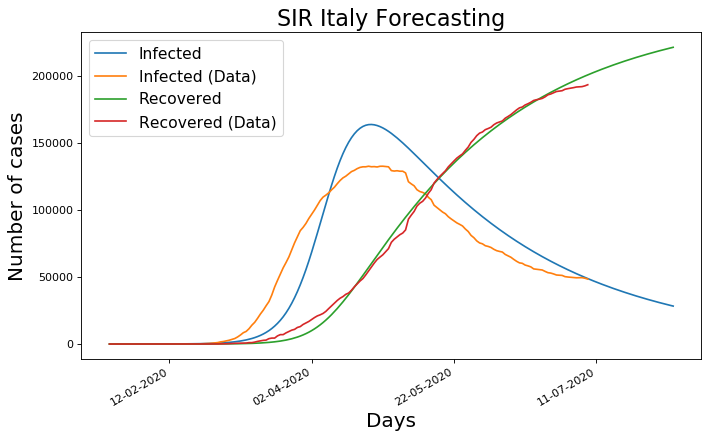

In [311]:
place = 'Italy' 
df = SIR_series(data_list=data_list, place=place, days=30, s0=250000, i0=2, r0=0)
sir_pred_plot(df, place)

      fun: 11767.827097895886
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.57899033e+09, -3.61639723e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 396
      nit: 19
   status: 0
  success: True
        x: array([9.53119294e-07, 5.68945190e-02])
country=Germany, beta=0.00000095, gamma=0.05689452, r_0:0.00001675


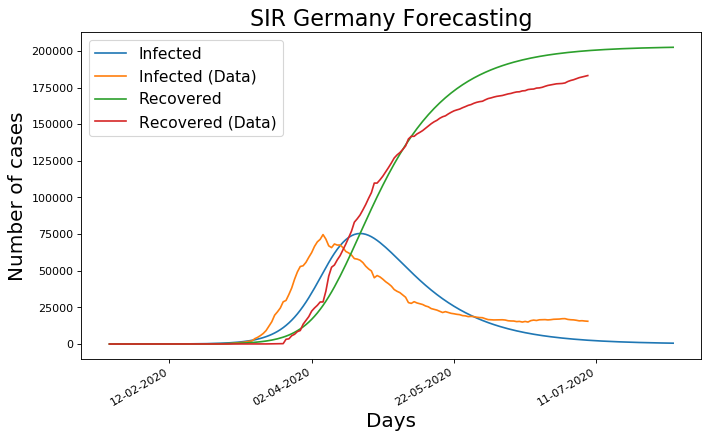

In [314]:
place = 'Germany' 
df = SIR_series(data_list=data_list, place=place, days=30, s0=210000, i0=2, r0=0)
sir_pred_plot(df, place)

## Vector Autoregression and Causality Test

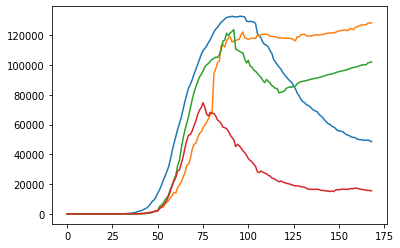

In [171]:
places = ['Italy', 'France', 'Spain', 'Germany']
ex = []
for j, i in enumerate(places):
    ex.append(data_list[0][data_list[0]['Country/Region']==i]['Cases'].values - data_list[1][data_list[1]['Country/Region']==i]['Cases'].values)
    plt.plot(ex[j])
    
plt.show()

In [172]:
d = dict(zip(places, ex))
df = pd.DataFrame(data=d)
df.head()

,Italy,France,Spain,Germany
0,0,0,0,0
1,0,0,0,0
2,0,2,0,0
3,0,3,0,0
4,0,3,0,0


In [173]:
# Created following: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

def adjust(val, length= 6): return str(val).ljust(length)

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

def invert_transformation(df_train, df_forecast, second_diff=1):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff==2:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 3rd Diff
        elif second_diff==3:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [174]:
maxlag=12
test = 'ssr_chi2test'
grangers_causation_matrix(df, variables = df.columns) 

,Italy_x,France_x,Spain_x,Germany_x
Italy_y,1.0,0.0,0.0,0.0
France_y,0.0,1.0,0.0,0.0
Spain_y,0.0,0.0,1.0,0.0
Germany_y,0.0,0.0,0.0,1.0


In [175]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Italy  ::  83.47     > 40.1749   =>   True
France ::  36.26     > 24.2761   =>   True
Spain  ::  5.7       > 12.3212   =>   False
Germany ::  0.98      > 4.1296    =>   False


In [176]:
nobs = 7
df_train, df_test = df[0:-nobs], df[-nobs:]
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Italy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5059
 No. Lags Chosen       = 10
 Critical value 1%     = -3.474
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.1141. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "France" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.9324
 No. Lags Chosen       = 4
 Critical value 1%     = -3.473
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.7771. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Spain" 
    -----------------------------------------------
 Null Hypothesis: Data has uni

In [177]:
# 1st difference
df_differenced = df_train.diff().dropna()
# Second Differencing
df_differenced = df_differenced.diff().dropna()
# Third Differencing
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Italy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0776
 No. Lags Chosen       = 13
 Critical value 1%     = -3.476
 Critical value 5%     = -2.882
 Critical value 10%    = -2.578
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "France" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0768
 No. Lags Chosen       = 14
 Critical value 1%     = -3.477
 Critical value 5%     = -2.882
 Critical value 10%    = -2.578
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Spain" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

In [178]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  61.11152276390042
BIC :  61.4991930212456
FPE :  3.4708339855920365e+26
HQIC:  61.26896053711875 

Lag Order = 2
AIC :  60.267382615555604
BIC :  60.96817783206859
FPE :  1.492829824731982e+26
HQIC:  60.55200011619471 

Lag Order = 3
AIC :  59.379170286958846
BIC :  60.395788956042026
FPE :  6.147789793743564e+25
HQIC:  59.79207677326873 

Lag Order = 4
AIC :  58.64654993899076
BIC :  59.981729990284364
FPE :  2.9608205001648765e+25
HQIC:  59.18887006520007 

Lag Order = 5
AIC :  58.02352345978379
BIC :  59.680043061100314
FPE :  1.593183836279747e+25
HQIC:  58.69639755814936 

Lag Order = 6
AIC :  57.67289359296829
BIC :  59.65357197296335
FPE :  1.1275981855414429e+25
HQIC:  58.47747796189512 

Lag Order = 7
AIC :  57.22082089363059
BIC :  59.52851918585537
FPE :  7.226201920008508e+24
HQIC:  58.15828809199523 

Lag Order = 8
AIC :  56.83840599526033
BIC :  59.4760281042641
FPE :  4.977978700030778e+24
HQIC:  57.90994514307258 

Lag Order = 9
AIC :  56.7698973119

/home/pier/anaconda3/envs/ai/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [179]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,63.58,63.66,4.088e+27,63.61
1,61.42,61.83,4.721e+26,61.58
2,60.56,61.29,2.004e+26,60.86
3,59.66,60.72,8.125e+25,60.09
4,58.91,60.29,3.841e+25,59.47
5,58.26,59.97,2.023e+25,58.96
6,57.89,59.92,1.398e+25,58.71
7,57.41,59.77,8.719e+24,58.37
8,56.99,59.68,5.827e+24,58.08
9,56.89,59.90,5.329e+24,58.11


In [180]:
model_fitted = model.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Jul, 2020
Time:                     17:57:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    59.7404
Nobs:                     150.000    HQIC:                   57.9767
Log likelihood:          -4961.11    FPE:                4.70867e+24
AIC:                      56.7699    Det(Omega_mle):     1.94938e+24
--------------------------------------------------------------------
Results for equation Italy
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              1.192846        60.064956            0.020           0.984
L1.Italy          -1.350909         0.097151          -13.905           0.000
L1.France          0.065122         0.035473            1.836           

In [181]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Italy  : 1.89
France : 2.03
Spain  : 2.03
Germany : 2.04


In [182]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

9


array([[ -638.,   216.,   118.,   315.],
       [  831.,  -558.,    70.,  -173.],
       [  534.,   384.,   -20.,   600.],
       [ -948.,  1563.,   -47.,  -242.],
       [  158., -2804.,   126.,  -349.],
       [  820.,   570.,  -408.,   270.],
       [ -707.,  3136.,   162.,    97.],
       [ -685., -3846.,   202.,  -330.],
       [ 1354.,  1807.,   -14.,  -381.]])

In [183]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Italy_2d,France_2d,Spain_2d,Germany_2d
162,-879.774229,-201.785673,155.914804,1021.519803
163,335.673065,351.762941,-382.787217,-328.528673
164,106.917144,-1271.140814,-496.607105,-225.460058
165,-159.092756,1237.033930,1329.581396,486.918714
166,43.143959,537.212266,-532.118299,-688.800832
167,-193.965568,-2123.622055,-721.117691,77.222438
168,170.051849,1659.047143,939.475802,111.943991


In [184]:
df_results = invert_transformation(df_train, df_forecast, second_diff=3)        
df_results.loc[:, ['Italy', 'France', 'Spain', 'Germany']]

,Italy,France,Spain,Germany
162,48876.225771,126748.214327,99826.914804,17289.519803
163,48045.124607,127541.191595,99988.042391,17457.510932
164,47320.940588,127063.028049,99652.562873,17400.042003
165,46437.663813,127821.898433,100646.664750,17829.491789
166,45597.530997,129117.981084,101108.648329,17570.140743
167,44563.432613,128290.441681,100849.514217,17388.012135
168,43699.386078,129121.949420,101529.855907,17317.827518


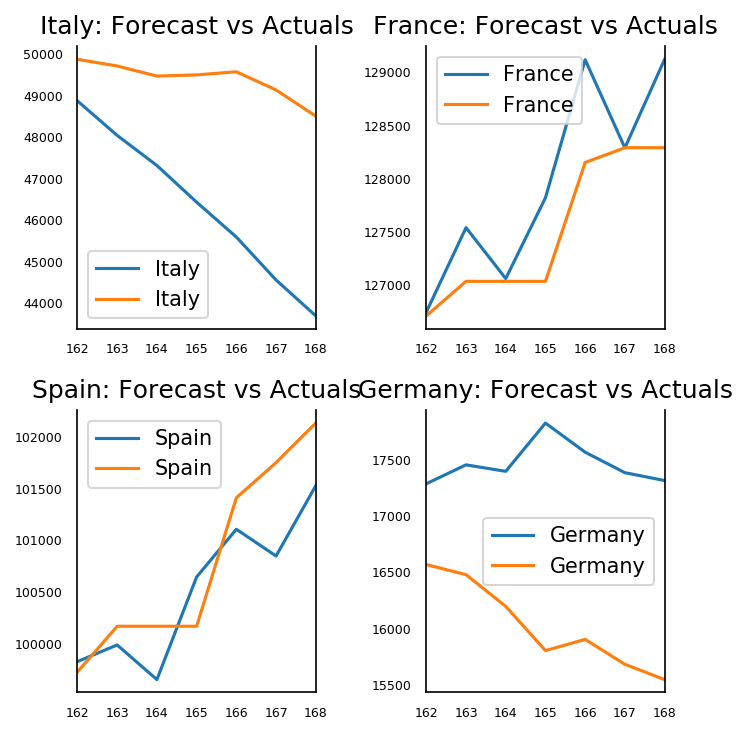

In [186]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(5, 5))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [187]:
for i in list(df_results.loc[:, ['Italy', 'France', 'Spain', 'Germany']].columns):
    print('Forecast Accuracy of: ' + i)
    accuracy_prod = forecast_accuracy(df_results[i].values, df_test[i])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Italy
mape   :  0.0617
me     :  -3037.2422
mae    :  3037.2422
mpe    :  -0.0617
rmse   :  3333.0728
corr   :  0.8862
minmax :  0.0617
Forecast Accuracy of: France
mape   :  0.0035
me     :  449.1007
mae    :  449.5459
mpe    :  0.0035
rmse   :  596.6812
corr   :  0.9055
minmax :  0.0035
Forecast Accuracy of: Spain
mape   :  0.0044
me     :  -276.5424
mae    :  441.5651
mpe    :  -0.0027
rmse   :  509.4742
corr   :  0.8849
minmax :  0.0044
Forecast Accuracy of: Germany
mape   :  0.0904
me     :  1438.3636
mae    :  1438.3636
mpe    :  0.0904
rmse   :  1504.5946
corr   :  -0.2415
minmax :  0.0822


## Darts

In [201]:
place = 'Germany'
daily_cases = data_list[0][data_list[0]['Country/Region']==place]['Cases'] - data_list[1][data_list[1]['Country/Region']==place]['Cases']

df = daily_cases.to_frame()
df.reset_index(level=0, inplace=True)
series = TimeSeries.from_dataframe(df, 'Dates', 'Cases')

In [254]:
train, val = series.split_before(pd.Timestamp('6/20/20'))

def eval_model(model, transform=False):
    pred_series = model.predict(len(val)+10)
    if transform==True:
        pred_series = transformer.inverse_transform(pred_series)
    plt.figure(figsize=(8,5))
    series.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val)))
    plt.legend();

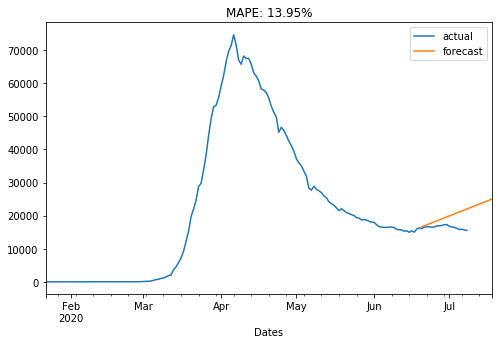

In [255]:
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))
eval_model(model)

/home/pier/anaconda3/envs/ai/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/pier/anaconda3/envs/ai/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/pier/anaconda3/envs/ai/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/pier/anaconda3/envs/ai/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/pier/anaconda3/envs/ai/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/pier/anaconda3/envs/ai/lib/python3.7/site-packages/statsmodels/bas

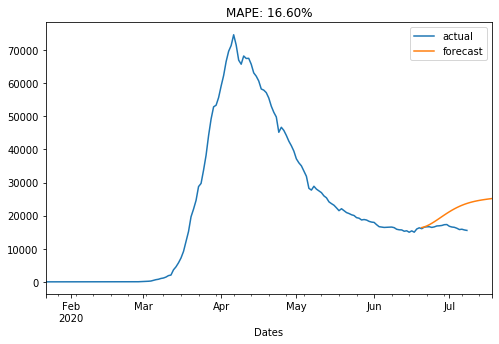

In [256]:
model_aarima = AutoARIMA()
model_aarima.fit(train)
eval_model(model_aarima)

In [257]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

lstm = RNNModel(
    model='LSTM',
    output_length=5,
    hidden_size=5,
    n_rnn_layers=1,
    input_length=1,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3},
    model_name='RNN', log_tensorboard=True
)

lstm.fit(train_transformed, val_transformed, verbose=True)  

best_model = RNNModel.load_from_checkpoint(model_name='RNN', best=True)

/home/pier/anaconda3/envs/ai/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead



Training loss: 0.0014, validation loss: 0.0001
loading model_best_290.pth.tar


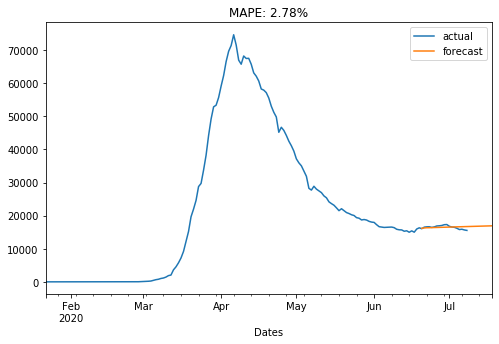

In [258]:
eval_model(best_model, transform=True)

In [261]:
tcnn = TCNModel(
    n_epochs=1000,
    input_length=5,
    output_length=1,
    dropout=0.01,
    dilation_base=3,
    weight_norm=True,
    kernel_size=4,
    num_filters=4,
    model_name='T_CNN', log_tensorboard=True
)

tcnn.fit(train_transformed, val_series=val_transformed, verbose=True)

[2020-07-09 18:36:19,563] INFO | darts.models.tcn_model | Number of layers chosen: 1
INFO:darts.models.tcn_model:Number of layers chosen: 1


/home/pier/anaconda3/envs/ai/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead



Training loss: 0.0077, validation loss: 0.0001


loading model_best_970.pth.tar


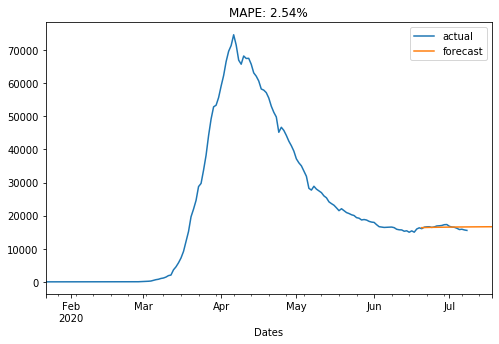

In [262]:
best_model2 = TCNModel.load_from_checkpoint(model_name='T_CNN', best=True)

eval_model(best_model2, transform=True)

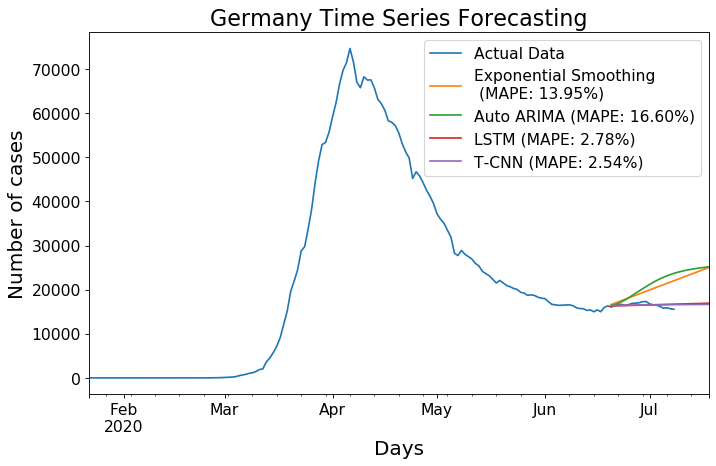

In [269]:
models = [model,model_aarima,best_model,best_model2]
pred_series = models[0].predict(len(val)+10)
pred_series2 = models[1].predict(len(val)+10)
pred_series3 = models[2].predict(len(val)+10)
pred_series3 = transformer.inverse_transform(pred_series3)
pred_series4 = models[3].predict(len(val)+10)
pred_series4 = transformer.inverse_transform(pred_series4)
    
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
series.plot(label='Actual Data')
pred_series.plot(label='Exponential Smoothing \n (MAPE: {:.2f}%'.format(mape(pred_series, val))+')')
pred_series2.plot(label='Auto ARIMA (MAPE: {:.2f}%'.format(mape(pred_series2, val))+')')
pred_series3.plot(label='LSTM (MAPE: {:.2f}%'.format(mape(pred_series3, val))+')')
pred_series4.plot(label='T-CNN (MAPE: {:.2f}%'.format(mape(pred_series4, val))+')')
plt.title(place+" Time Series Forecasting", fontsize=20)
plt.legend(fontsize=14)
plt.xlabel("Days", fontsize=18)
plt.ylabel("Number of cases", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(place+'_darts.svg', format='svg', bbox_inches='tight')
plt.show()